In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import torch.nn as nn

In [2]:
x, y = make_moons(n_samples= 1000, noise= 0.2)


Text(0, 0.5, 'x_2')

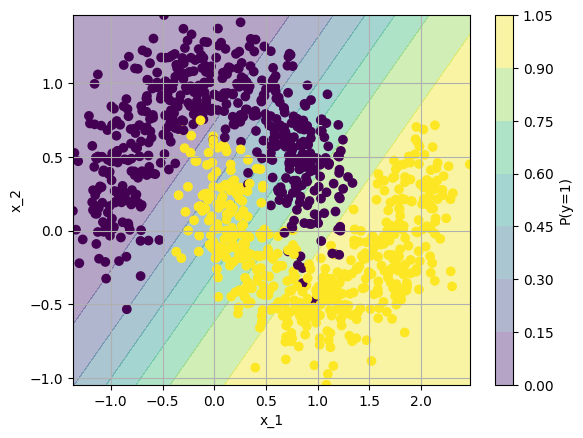

In [38]:
w1 = 2.1
w2 = -2.1
b = -0.2

x1 = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 100)
x2 = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 100)
xx1 , xx2 = np.meshgrid(x1, x2)
yy = w1*xx1 + w2 * xx2 +b
zz = 1.0/(1.0+np.exp(-yy))

c = plt.contourf(xx1,xx2, zz, alpha=0.4)
plt.clim(0,1)
plt.scatter(x[:,0], x[:,1], c=y)
plt.colorbar(c, label='P(y=1)')

plt.grid('on')
plt.xlabel("x_1")
plt.ylabel("x_2")